# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
from absl import logging
from tensorflow.keras import layers
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import sklearn.metrics

import warnings
warnings.filterwarnings('ignore')

# Download Kaggle Data
You don't need to run these commands every time, just once is enough to save the Kaggle data to Google Drive.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Data Science/Kaggle"

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 47.0MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 78.4MB/s]
 53% 14.0M/26.3M [00:00<00:00, 53.0MB/s]
100% 26.3M/26.3M [00:00<00:00, 87.8MB/s]
 85% 20.0M/23.4M [00:00<00:00, 84.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 93.0MB/s]


In [ ]:
!ls

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         

Archive:  train.csv.zip
  inflating: train.csv               

4 archives were successfully processed.


# Collect Data

In [ ]:
path = "/content/drive/MyDrive/Data Science/Kaggle"

In [ ]:
train_df = pd.read_csv(path + '/train.csv', low_memory=False)
test_df = pd.read_csv(path + '/test.csv', low_memory=False)
test_labels_df = pd.read_csv(path + '/test_labels.csv', low_memory=False)

In [ ]:
train_df.columns, test_df.columns, test_labels_df.columns

(Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
        'insult', 'identity_hate'],
       dtype='object'),
 Index(['id', 'comment_text'], dtype='object'),
 Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
        'identity_hate'],
       dtype='object'))

In [ ]:
train_df.shape, test_df.shape, test_labels_df.shape

((159571, 8), (153164, 2), (153164, 7))

In [ ]:
comment_labels = list(test_labels_df.columns[1:])
comment_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
train_length = int(0.7 * len(train_df))
val_df = train_df[train_length:]
train_df = train_df[:train_length]
train_df.shape, val_df.shape

((111699, 8), (47872, 8))

In [ ]:
train_df['labels'] = train_df[comment_labels].values.tolist()
train_df['labels'] = np.array(train_df.labels)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
val_df['labels'] = val_df[comment_labels].values.tolist()
val_df['labels'] = np.array(val_df.labels)
val_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
111699,55858b89f99e9bda,Hope he dies \n\nNow this Atheist filth's wife...,1,0,0,1,1,0,"[1, 0, 0, 1, 1, 0]"
111700,5586a218c2393d06,What do you mean? Could you explain your point...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
111701,5588be8efb4c1515,"""\nWell, the finals are just as popular(maybe ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
111702,558a1f3d0f4fcc03,User: Johnleemk Please Stop vandalizing wiki u...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
111703,558e22e3c617327e,Greg's Apology\n\nA while back I added Greg's ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
#YOU DON'T NEED TO RUN THIS EVERY TIME, valid.csv already exists in Google Drive
val_df.to_csv(f'{path}/valid.csv', index = False)

# Visualize Data

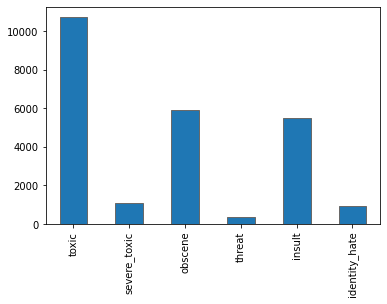

In [ ]:
train_df[comment_labels].sum().plot(kind='bar', edgecolor = 'dimgrey');
plt.xticks(rotation = 90);

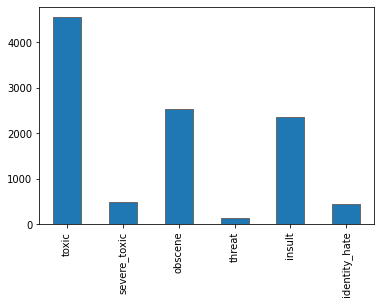

In [ ]:
val_df[comment_labels].sum().plot(kind='bar', edgecolor = 'dimgrey');
plt.xticks(rotation = 90);

In [ ]:
NUM_LABELS = len(comment_labels)
print(f'There are {NUM_LABELS} labels.')

There are 6 labels.


# Create Datasets

In [ ]:
def create_dataset(df, input_col, labels_col):
  """Take specific columns from a dataframe, and convert to NumPy array to be 
  taken by neural network."""
  inputs = np.array(df[input_col].tolist())
  targets = np.array(df[labels_col].tolist())
  targets = tf.cast(targets, tf.float32)
  return inputs, targets

In [ ]:
X_train, y_train = create_dataset(train_df, 'comment_text', 'labels')
X_train, y_train

(array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
        "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
        "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
        ...,
        '" ""victims"".  And even those insurrectionists who perished because they felt compelled to take matters into their own hands because they could/would no longer tolerate bondage or the dehumanization of their kin as human chattel  were they no less"',
        '"\n - The fact is, I was on an Administrator\'s talk page if he had fel

In [ ]:
X_val, y_val = create_dataset(val_df, 'comment_text', 'labels')
X_val, y_val

(array(["Hope he dies \n\nNow this Atheist filth's wife has gone, he should follow soon and give us all a rest from him Paedophillic behaviour.",
        'What do you mean? Could you explain your point further pls ? JohnQ',
        '"\nWell, the finals are just as popular(maybe a percent lower) as the World Cup Finals is in Europe, so that should give you some idea and as the World Cup 2006 top 4 teams (6 of the top 8 and 10 of the top 16) were European, so if you win you can almost claim that you are the best in the world. For example, France took the FIFA world ranking top spot not when they won the World Cup 98, but when they won the Euro 2000.  \xa0  \n\n"',
        ...,
        'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
        'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
        '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad ri

In [ ]:
X_test = np.array(test_df['comment_text'].tolist())
X_test

array(["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
       '== From RfC == \n\n The title is fine as it is, IMO.',
       '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "', ...,
       '" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is ""more correct.""  I had gotten confused, but then found this: \n :... while acknowledging Japan\'s territorial rights to Okinotorishima itself ... \n However, is there a category for  \n :... did not acknowledge Japan\'s claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for ""disputed EEZ""s?   "',
       '" \n\n == ""One of the founding n

# Train & Tune Model
Only run the code in this section if you are training a new neural network.

In [ ]:
def run_model(hidden_nodes, learning_rate, epochs, dropout, l2, loss_fn, metric):
  """Build, fit and evaluate model given hyperparameters.
  Returns loss and accuracy."""
  model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(hidden_nodes, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=l2), name='hidden_layer'),
    layers.Dropout(dropout),
    layers.Dense(NUM_LABELS, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(l2=l2), name='output')
    ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=loss_fn,
              metrics=metric)
  
  history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [callback])
  
  loss, accuracy = model.evaluate(X_val, y_val)
  results = {'loss': loss, 'accuracy': accuracy}

  return results

In [ ]:
#DON'T RUN UNLESS YOU ARE TUNING HYPERPARAMETERS!
hidden_nodes = [32, 64, 128]
learning_rates = np.linspace(1e-5, 1e-4, 3)
tuning_epochs = 3 
loss_fns = ['binary_crossentropy']
metrics = ['AUC']
dropouts = np.linspace(0, 0.9, 3)
l2s = [0.01, 0.015, 0.02]

tuning_results = {'hidden_nodes': [], 'learning_rates': [], 'dropouts': [], 'l2s': [], 'loss_fns': [], 'metrics': [], 'val_loss': [], 'val_accuracy': []}

for h in hidden_nodes:
  for r in learning_rates:
    for d in dropouts:
      for l in loss_fns:
        for l2 in l2s:
          for m in metrics:
            results = run_model(h, r, tuning_epochs, d, l2, l, m)
            tuning_results['hidden_nodes'].append(h)
            tuning_results['learning_rates'].append(r)
            tuning_results['dropouts'].append(d)
            tuning_results['l2s'].append(l2)
            tuning_results['loss_fns'].append(l)
            tuning_results['metrics'].append(m)
            tuning_results['val_loss'].append(results['loss'])
            tuning_results['val_accuracy'].append(results['accuracy'])

tuning_results_df = pd.DataFrame(tuning_results)

Epoch 1/3
1746/1746 [==============================] - 124s 71ms/step - loss: 1.2459 - auc: 0.5789 - val_loss: 1.1166 - val_auc: 0.6427
Epoch 2/3
1746/1746 [==============================] - 120s 69ms/step - loss: 1.0126 - auc: 0.6726 - val_loss: 0.9185 - val_auc: 0.7137
Epoch 3/3
1496/1496 [==============================] - 39s 26ms/step - loss: 0.7716 - auc: 0.7343
Epoch 1/3
1746/1746 [==============================] - 111s 63ms/step - loss: 1.5438 - auc: 0.5004 - val_loss: 1.3553 - val_auc: 0.5473
Epoch 2/3
1746/1746 [==============================] - 109s 62ms/step - loss: 1.2079 - auc: 0.5690 - val_loss: 1.0768 - val_auc: 0.5967
Epoch 3/3
1496/1496 [==============================] - 36s 24ms/step - loss: 0.8838 - auc: 0.6062
Epoch 1/3
1746/1746 [==============================] - 107s 61ms/step - loss: 1.8098 - auc: 0.4444 - val_loss: 1.5648 - val_auc: 0.4473
Epoch 2/3
1746/1746 [==============================] - 105s 60ms/step - loss: 1.3741 - auc: 0.4535 - val_loss: 1.2053 - val_

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f5198fd1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


 505/1496 [=========>....................] - ETA: 22s - loss: 0.3138 - auc: 0.8041

KeyboardInterrupt: ignored

In [ ]:
#DON'T RUN UNLESS YOU ARE TUNING HYPERPARAMETERS!
tuning_results_df.to_pickle('/content/drive/MyDrive/Data Science/toxic_tuning_results_df.pkl')

In [ ]:
model.save_weights('/content/drive/MyDrive/Data Science/Kaggle/toxic_end_checkpoint.ckpt')

# Create Instance of Tuned Model
(Start here if you aren't training a new model).

In [ ]:
feature_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape = [], dtype=tf.string, trainable=False)

In [ ]:
#set early stopping (ie. validation loss hook)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', patience = 2)

In [ ]:
best_params = {'dropouts': 0.0,
                'hidden_nodes': 32,
                'l2s': 0.01,
                'learning_rates': 0.0001,
                'loss_fns': 'binary_crossentropy',
                'metrics': 'AUC',
              }

In [ ]:
best_model.save_weights('/content/drive/MyDrive/Data Science/toxic_end_checkpoint.ckpt')

In [ ]:
def create_model(hidden_nodes, learning_rate, dropout, loss_fn, metric):
  """Build, fit and evaluate model given hyperparameters.
  Returns loss and accuracy."""
  model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(hidden_nodes, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), name='hidden_layer'),
    layers.Dropout(dropout),
    layers.Dense(NUM_LABELS, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), name='output')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=loss_fn,
              metrics=metric)
  return model

In [ ]:
#create model instance
new_model = create_model(best_params['hidden_nodes'], best_params['learning_rates'], best_params['dropouts'], best_params['loss_fns'], best_params['metrics'])

#load saved model
new_model.load_weights('/content/drive/MyDrive/Data Science/toxic_end_checkpoint.ckpt')

In [ ]:
def create_model(hidden_nodes, learning_rate, dropout, loss_fn, metric):
  """Build, fit and evaluate model given hyperparameters.
  Returns loss and accuracy."""
  model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(hidden_nodes, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), name='hidden_layer'),
    layers.Dropout(dropout),
    layers.Dense(NUM_LABELS, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), name='output')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=loss_fn,
              metrics=metric)
  return model

# Evaluate Model

In [ ]:
new_model.evaluate(X_val, y_val)

1496/1496 [==============================] - 35s 23ms/step - loss: 0.2427 - auc: 0.8468


[0.24267783761024475, 0.8468178510665894]

## Visualize Predictions

In [ ]:
raw_val_preds = new_model.predict(X_val)
raw_val_preds_df = pd.DataFrame(raw_val_preds)
raw_val_preds_df.columns = comment_labels
raw_val_preds_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.135385,0.075635,0.106341,0.075113,0.102184,0.074425
1,0.134800,0.075180,0.105801,0.074686,0.101644,0.073969
2,0.147047,0.085736,0.117607,0.085259,0.113271,0.084448
3,0.115358,0.059544,0.087450,0.059202,0.083746,0.058476
4,0.103566,0.050763,0.076699,0.050550,0.073264,0.049785


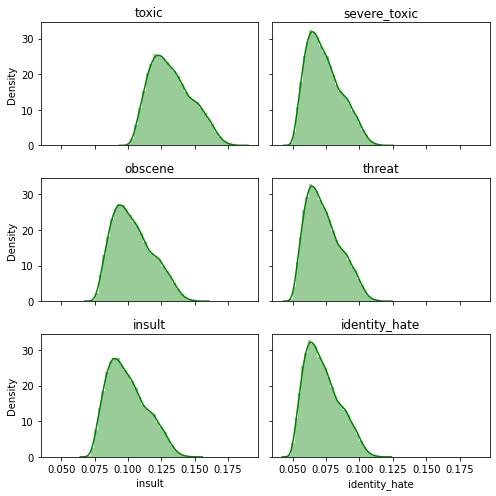

In [ ]:
rows = 3
cols = 2
fig, axs = plt.subplots(rows,cols, figsize=(7,7), sharex=True, sharey=True)
i = 0

for r in range(rows):
  for c in range(cols):
    sns.distplot(raw_val_preds_df[comment_labels[i]], bins=30, kde=True, color="g", ax=axs[r,c])
    axs[r, c].set_title(f'{comment_labels[i]}')
    i += 1

plt.tight_layout()
plt.show()

## Tune Classification Threshold

In [ ]:
#loop through labels and thresholds for each label to maximize F1 score per label

best_thresholds = {}

for i in range(len(comment_labels)):
  min_thresh, max_thresh = min(raw_val_preds[:,i]), max(raw_val_preds[:,i])
  thresholds = np.linspace(min_thresh, max_thresh, 5)
  best_f1 = 0
  best_thresh = 0

  for thresh in thresholds:
    f1 = sklearn.metrics.f1_score(y_val[:,i], (raw_val_preds[:,i] > thresh).astype('int'))
    if f1 > best_f1:
      best_f1 = f1
      best_thresh = thresh

  best_thresholds.update({f'{comment_labels[i]}': {'best_f1': best_f1, 'best_thresh': best_thresh}})
  print(f'Label: {comment_labels[i]}, Best Threshold: {best_thresh}, Best F1 Score: {best_f1}')

Label: toxic, Best Threshold: 0.14187921956181526, Best F1 Score: 0.3098350362463611
Label: severe_toxic, Best Threshold: 0.10257540177553892, Best F1 Score: 0.17780938833570414
Label: obscene, Best Threshold: 0.1347789615392685, Best F1 Score: 0.24369524820812316
Label: threat, Best Threshold: 0.10190705675631762, Best F1 Score: 0.029732408325074337
Label: insult, Best Threshold: 0.13026473857462406, Best F1 Score: 0.2173546756529065
Label: identity_hate, Best Threshold: 0.10124224238097668, Best F1 Score: 0.1003690036900369


In [ ]:
val_preds_df = pd.DataFrame()

for label in comment_labels:
  val_preds_df[label] = (raw_val_preds_df[label] > best_thresholds[label]['best_thresh']).astype('int')

val_preds_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [ ]:
y_val_df = pd.DataFrame(y_val, columns=comment_labels)
val_diff_df = y_val_df.eq(val_preds_df).astype(int)
val_diff_df.columns = comment_labels
val_diff_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,1,1,0,0,1
1,1,1,1,1,1,1
2,0,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1


In [ ]:
val_diff_df.mean().mean()

0.9266063669786097

## Classification Report

In [ ]:
report = sklearn.metrics.classification_report(y_val, val_preds_df.values, target_names = comment_labels)

print(report)

               precision    recall  f1-score   support

        toxic       0.21      0.60      0.31      4559
 severe_toxic       0.14      0.25      0.18       491
      obscene       0.37      0.18      0.24      2525
       threat       0.02      0.11      0.03       136
       insult       0.32      0.16      0.22      2356
identity_hate       0.08      0.15      0.10       449

    micro avg       0.21      0.36      0.26     10516
    macro avg       0.19      0.24      0.18     10516
 weighted avg       0.26      0.36      0.25     10516
  samples avg       0.05      0.04      0.04     10516



## Confusion Matrix

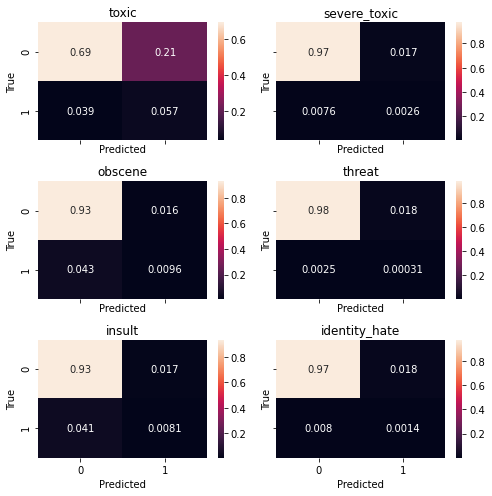

In [ ]:
cm = sklearn.metrics.multilabel_confusion_matrix(y_val, val_preds_df.values)

rows = 3
cols = 2
fig, axs = plt.subplots(rows,cols, figsize=(7,7), sharex=True, sharey=True)
i = 0

for r in range(rows):
  for c in range(cols):
    mat = cm[i] / cm[i].sum()
    sns.heatmap(mat, annot=True, ax=axs[r,c])
    axs[r, c].set_title(f'{comment_labels[i]}')
    axs[r, c].set_xlabel('Predicted')
    axs[r, c].set_ylabel('True')
    i += 1

plt.tight_layout()
plt.show()

# Predict on Test Set

In [ ]:
raw_test_preds_df = pd.DataFrame(new_model.predict(X_test), columns=comment_labels)

test_preds_df = pd.DataFrame()

for cat in comment_labels:
  test_preds_df[cat] = (raw_test_preds_df[cat] > best_thresholds[cat]['best_thresh']).astype('int')


test_preds_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [ ]:
raw_test_preds_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.146690,0.085164,0.117351,0.084300,0.112938,0.083885
1,0.124212,0.066600,0.095716,0.066317,0.091824,0.065462
2,0.141376,0.080817,0.112091,0.080378,0.107862,0.079564
3,0.117010,0.060928,0.089011,0.060689,0.085251,0.059840
4,0.135783,0.076027,0.106684,0.075599,0.102547,0.074813


## Create dataframe to submit to Kaggle

In [ ]:
sub_df = raw_test_preds_df.copy()
sub_df['id'] = test_df['id']
cols = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sub_df = sub_df[cols]

sub_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.146690,0.085164,0.117351,0.084300,0.112938,0.083885
1,0000247867823ef7,0.124212,0.066600,0.095716,0.066317,0.091824,0.065462
2,00013b17ad220c46,0.141376,0.080817,0.112091,0.080378,0.107862,0.079564
3,00017563c3f7919a,0.117010,0.060928,0.089011,0.060689,0.085251,0.059840
4,00017695ad8997eb,0.135783,0.076027,0.106684,0.075599,0.102547,0.074813


In [ ]:
sub_df.to_csv('submission.csv', index=False)

In [ ]:
SUB_PATH = f"{path}/submission.csv"
!kaggle competitions submit -c 'jigsaw-toxic-comment-classification-challenge' -f 'submission.csv' -m '1st submission with Universal Sentence Encoder'

100% 12.6M/12.6M [00:02<00:00, 6.26MB/s]
Successfully submitted to Toxic Comment Classification Challenge